# Combining Data sources

In [79]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from langdetect import detect
from langdetect import DetectorFactory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

## Dataset 1 (kaggle-1)

Datset: https://www.kaggle.com/c/fake-news/data

In [2]:
kaggle_1 = pd.read_csv('E:\Major project\data\kaggle_1_tr.csv')

In [3]:
kaggle_1.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
print(f'Datapoints in train-data for kaggle-1 dataset: {kaggle_1.shape[0]}')

Datapoints in train-data for kaggle-1 dataset: 20800




* We've about 20,800 datapoints coming from the kaggle-1 dataset

In [14]:
# Checking for missing data 

kaggle_1.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

* There are few instances where the author, title and body are missing which we'l try taking care of later
* It'll make sense to drop the 'author' feature since the other datasets do not have the 'author' feature
* Another important thing that can be done is to use common feature names across all the datasets like 'title', 'body' and 'label'

In [26]:
kaggle_1 = kaggle_1.rename(columns={'text': 'body'})
kaggle_1.drop(['author', 'id'], axis=1, inplace=True)
kaggle_1.head()

,title,body,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


In [2]:
# Defining a function that gets lengths of all instances in a series (title and body for instance)
# While the same task can simply be achieved using a simply apply(len) function on the feature whose length be want, it fails when there are NaN values. 
# We could always remove the instaces with NaN values but for later analysis it can be helpful. Thus its better to write a custom function that works even when NaN's are present

def get_length(series):
    
    """
        Given a series, the function returns the length of text for all instances in the series in a list. 
        This function works well even when NaNs are present in the series.
        
        Parameter: Takes in a series that contains text data.
        
        Output: Returns two lists such that one contains the number of words per sentence and the other returns the number of letters in the sentence
    """
    
    series_list = series.values # Converting the series to a list
    length_of_words = []   # List to store all the lengths. Here length refers to the number of words in each sentence
    total_letters = []     # List to store all the number of letters per sentence
    
    for sentence in series_list:
        # Checking whether the sentence is np.nan. Since we're dealing with text data, the only case where the type of a sentence would be float is when its NaN
        if type(sentence) == float:   
            length_of_words.append(np.nan)
            total_letters.append(np.nan)
        else: 
            total_letters.append(len(sentence))   # Number of letters in the sentence
            length_of_words.append(len(sentence.split()))  # Length of the sentence as in number of words in the sentence
            
    return length_of_words, total_letters

In [85]:
title_num_words, title_num_letters = get_length(kaggle_1['title'])
body_num_words, body_num_letters = get_length(kaggle_1['body'])

kaggle_1['title_num_words'] = title_num_words
kaggle_1['title_num_letters'] = title_num_letters
kaggle_1['body_num_words'] = body_num_words
kaggle_1['body_num_letters'] = body_num_letters

In [86]:
kaggle_1.head()

,title,body,label,title_num_words,title_num_letters,body_num_words,body_num_letters
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,14.0,81.0,820.0,4930.0
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,9.0,55.0,710.0,4160.0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,7.0,33.0,1266.0,7692.0
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,10.0,63.0,557.0,3237.0
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,14.0,93.0,154.0,938.0


In [87]:
# Now that we have the lengths, we can do some basic analysis 

kaggle_1.drop('label', axis=1).describe()

,title_num_words,title_num_letters,body_num_words,body_num_letters
count,20242.000000,20242.000000,20761.000000,20761.000000
mean,12.420709,74.319336,760.308126,4552.715380
std,4.098735,23.161910,869.525988,5130.563491
min,1.000000,3.000000,0.000000,1.000000
25%,10.000000,60.000000,269.000000,1628.000000
50%,13.000000,75.000000,556.000000,3361.000000
75%,15.000000,88.000000,1052.000000,6275.000000
max,72.000000,456.000000,24234.000000,142961.000000


In [97]:
# It would make sense to have a look at the article with 24234 words and also the article which has 142,961 letters in it since these numbers are insanely high!

# Checking the first 100 words
kaggle_1.iloc[kaggle_1['body_num_words'].argmax()]['body'][:100]

'The Hard Working American vs. The Government Parasite By Michael Snyder, on April 10th, 2012 \nWhich '

In [96]:
# First 100 words of the article containing most number of letters

kaggle_1.iloc[kaggle_1['body_num_letters'].argmax()]['body'][:100]

'Заседание Международного дискуссионного клуба «Валдай» Владимир В. Путин Сеть Вольтер | Сочи (Россия'

#### Observation:
* On expanding the article with most number of words, it is revealed that the articles can contain emojis as well. We'll have to take care of this later
* On expanding the article with most number of letters, we see a different language all together. By putting the sentence into Google Translate, it looks like the language is Russian.
This means that the data also contains
articles of different languages which we'll have to get rid off later
* There also are instances where there's only one word in the title and zero words in the body

In [201]:
# In order to detect whether articles are in english or not, we can use a really nice library called 'langdetect' https://pypi.org/project/langdetect/
# langdetect best detects language when there are atleast a few words in the sentence
# Thus we split the data into data having less than 3 words and data having more than 3 words

less_than_3_words = kaggle_1[kaggle_1['body_num_words'] < 3].reset_index()  # Contains all instances where there are less than 3 words in the body
more_than_3_words = kaggle_1[kaggle_1['body_num_words'] > 3].reset_index()  # Contains all instances where there are more than 3 words in the body

In [113]:
len(less_than_3_words)  # there are 114 articles with less than 3 words

114

In [202]:
# The code below goes over all the articles in the dataframe having more than 3 words in the body and checks whether they're english or not

DetectorFactory.seed = 0

non_english_articles = 0  
idx_list = []  # List to store the indices of the non-english articles
langs = []  # list to store all languages encountered that aren't english
for idx in tqdm(range(len(more_than_3_words['body']))):
#, article_body in enumerate(tqdm(more_than_3_words['body'])):   
    language_of_text = detect(more_than_3_words['body'][idx])
    if language_of_text != 'en':
        non_english_articles += 1
        langs.append(language_of_text)
        idx_list.append(idx)

100%|████████████████████████████████████████████████████████████████████████████| 20626/20626 [05:06<00:00, 67.28it/s]


In [203]:
# Printing all the non-enlish languages

print(set(langs))
print(f'\nThere are {len(set(langs))} languages apart from English')
print(f'\nThere are {non_english_articles} articles in the dataset that are Non-English')

{'no', 'tl', 'cy', 'id', 'zh-cn', 'hr', 'tr', 'pl', 'el', 'ar', 'es', 'nl', 'fr', 'pt', 'it', 'fi', 'de', 'ru'}

There are 18 languages apart from English

There are 482 articles in the dataset that are Non-English


In [210]:
# Printing the first 10 Non-English articles 

for i,idx in enumerate(idx_list[:10]):
    text = more_than_3_words['body'][idx][:100]
    print(f'\nArticle {i+1}: {text}')
    print(f'Language in article {i+1}: {langs[i]}')
    print('-'*120)


Article 1: 0 комментариев 0 поделились Фото: AP 
Однако глава правительства Сербии Александр Вучич отказался ко
Language in article 1: ru
------------------------------------------------------------------------------------------------------------------------

Article 2: Страна: Китай Заявления КНДР о завершении своей программы развития ядерного оружия вызвали всплеск д
Language in article 2: ru
------------------------------------------------------------------------------------------------------------------------

Article 3: La expresión “no, lo siguiente” ya es la más utilizada no, lo siguiente, en el castellano SE HA HECH
Language in article 3: es
------------------------------------------------------------------------------------------------------------------------

Article 4: +++ Hände weg vom Alkohol: Schreiner rührt nach Arbeitsunfall keine Spirituosen mehr an +++ +++ An d
Language in article 4: de
---------------------------------------------------------------------------------

In [218]:
# Now that we have all the indices of all the articles that are non English, we can also obtain the indices for the articles that are English

all_indices = list(np.arange(more_than_3_words.shape[0]))  # Has all indices in the dataframe more_than_3_words. The indices go from 0 to 20,625
filtered_indices = []  # To store the filtered English articles only

for idx in all_indices:
    if idx not in idx_list:  # If index not present in the list of indices belonging to non-english articles
        filtered_indices.append(idx)
print(len(filtered_indices))  

20144


In [221]:
# Now that we have all the indices of the english articles, we can update the initial dataframe to 

more_than_3_words = more_than_3_words.iloc[filtered_indices]

In [229]:
# Since at the start we had split the data into 2 parts: more_than_3_words and less_than_3_words, we need to combine them again now

kaggle_1 = more_than_3_words.append(less_than_3_words, ignore_index=True) 

In [241]:
kaggle_1.head()

,index,title,body,label,title_num_words,title_num_letters,body_num_words,body_num_letters
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,14.0,81.0,820.0,4930.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,9.0,55.0,710.0,4160.0
2,2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,7.0,33.0,1266.0,7692.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,10.0,63.0,557.0,3237.0
4,4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,14.0,93.0,154.0,938.0


In [242]:
# Saving the csv file

kaggle_1.drop('index', axis=1, inplace=True)
kaggle_1.to_csv('E:\Major project\data\kaggle_1_filtered', index=False)

## Dataset 2 (kaggle-2)
    
   Dataset: https://www.kaggle.com/jruvika/fake-news-detection
    
   The problem with dataset 2 is that unlike dataset 1 and dataset 3, the source of the data doesn't mention / specify anywhere what class labels 1 and 0 mean. By the convention that we're going with, we want class 1 to mean Fake article and class 0 to mean True article. 
    One thing we could do is assume that the data makers have by default made class 1 to mean fake articles. But that would be a big gamble and could lead to the model learning false information. After searching up a bit about this problem, a fellow kaggler used a nice analysis to make an educated guess at what is what. 
    
   Reference Link: https://www.kaggle.com/quentinfu/word2vec-and-lstm-98-accuracy
    
   We would use part of the work to simplify our process of understanding the class label
    
   The approach is that we can use the URLs of the articles and extract the website from which the article originated from to better make guesses about the labels. This is a better way of knowing which label means Fake as reading the articles in class 0 and 1 to guess the class label didn't turn out so well for us as its pretty hard to differentite Fake articles from the True ones 

In [2]:
kaggle_2 = pd.read_csv('E:\Major project\data\kaggle_2_csv.csv')

In [3]:
kaggle_2.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [4]:
print(f'Datapoints in data for kaggle-2 dataset: {kaggle_2.shape[0]}')

Datapoints in data for kaggle-2 dataset: 4009


* We've 4009 datapoints present in the kaggle-2 dataset

In [24]:
# Verifying what the labels signify 
# Reference : https://www.kaggle.com/quentinfu/word2vec-and-lstm-98-accuracy

kaggle_2['website'] = kaggle_2['URLs'].apply(lambda url: url.split('/')[2])

In [25]:
# Now we have the websites from which the articles originated from

kaggle_2.head()  

,URLs,Headline,Body,Label,website
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,www.bbc.com
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1,www.reuters.com
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1,www.nytimes.com
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1,www.reuters.com
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1,www.cnn.com


In [26]:
kaggle_2.pivot_table(index='website', columns='Label', values='URLs', aggfunc='count').fillna(0).astype(int)

Label,0,1
website,,
abcnews.go.com,0,57
api.content-ad.net,2,0
beforeitsnews.com,1694,0
bleacherreport.com,0,8
clarivate.com,0,3
cnn.it,0,1
dailybuzzlive.com,99,0
edition.cnn.com,0,16
inhealth.cnn.com,0,14


The following conclusions can be drawn from the table above:
* Its clear that articles that are present in the data from the same websites only belong to class 0 or class 1
* For example known / reputed sources like bbc, bleacher report, reuters etc. all have articles that only belong to class 1 whereas sites like 'before its news' and 'activist post' have articles that have been labelled as class 0
* This heavily points to the fact that:     

        class 0 ==> Fake news 
        class 1 ==> Real news
        
        
    This is contrary to the assumption we'd have had that class 1 is Fake and class 0 is True. Now that we're sure, we can go forward with reversing the class labels 

In [27]:
# Reverse the labels

kaggle_2['Label'] = kaggle_2['Label'].map({1:0, 0:1})

In [29]:
# Renaming the columns of the dataset to enforce uniformity across all the datasets

kaggle_2 = kaggle_2.rename(columns={'Headline': 'title', 'Body': 'body', 'Label': 'label'})
kaggle_2.drop(['URLs', 'website'], axis=1, inplace=True)  # Dropping columns we won't be needing now on
kaggle_2.head()

,title,body,label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,0
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",0
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,0
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,0
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",0


In [32]:
# Adding lengths of the title and body features in the same way they were added for dataset 1

title_num_words, title_num_letters = get_length(kaggle_2['title'])
body_num_words, body_num_letters = get_length(kaggle_2['body'])

kaggle_2['title_num_words'] = title_num_words
kaggle_2['title_num_letters'] = title_num_letters
kaggle_2['body_num_words'] = body_num_words
kaggle_2['body_num_letters'] = body_num_letters

In [34]:
kaggle_2.drop('label', axis=1).describe()

,title_num_words,title_num_letters,body_num_words,body_num_letters
count,4009.000000,4009.000000,3988.000000,3988.000000
mean,9.800698,60.104016,488.887663,2941.288365
std,3.848936,22.660900,514.447982,3076.316585
min,1.000000,6.000000,10.000000,66.000000
25%,8.000000,48.000000,85.000000,557.500000
50%,10.000000,60.000000,351.500000,2115.000000
75%,11.000000,69.000000,725.250000,4311.250000
max,110.000000,653.000000,5610.000000,32767.000000


In [36]:
# Having a look at the largest articles 

print(kaggle_2.iloc[kaggle_2['body_num_words'].argmax()]['body'][:1000]) # First 1000 characters

(CNN) One was a man who died shielding his wife from gunfire on their wedding anniversary. Another was a city of Las Vegas employee who died in his boyfriend's arms. And two others were a veteran corrections officer and his girlfriend who died on the trip they had planned for weeks.
At least 58 people were killed and nearly 500 others were injured Sunday night, authorities say, when a gunman fired on an outdoor country musical festival from the 32nd floor of a Las Vegas hotel in the deadliest mass shooting in modern American history.
Here are some of the victims' stories:
Teresa Nicol Kimura
Teresa Nicol Kimura, known as Nicol, was at the concert with six friends, said Ryan Miller, pastor at For His Glory Community Church in Fullerton, California.
Miller was among those friends. He said they all scattered when the shooting started. After the rest of the group reconnected, the friends learned Kimura had died.
Kimura, 38, of Placentia, California, worked for the California Department of 

In [38]:
# Checking for missing values

kaggle_2.isna().sum()

title                 0
body                 21
label                 0
title_num_words       0
title_num_letters     0
body_num_words       21
body_num_letters     21
dtype: int64

In [44]:
print(f'Percentage of missing articles: {round((21 / kaggle_2.shape[0] * 100),2)} %')

Percentage of missing articles: 0.52 %


In [46]:
# Since there are very few instance of missing data, it'll be better to get rid of these 21 articles instead of coming up with some way of filling something in

kaggle_2.dropna(inplace=True)

In [49]:
# Saving the csv file

kaggle_2.to_csv('E:\Major project\data\kaggle_2_filtered', index=False)

## Dataset 3 (ISOT)

Dataset: https://www.uvic.ca/engineering/ece/isot/datasets/fake-news/index.php

In [55]:
isot_data_true = pd.read_csv('E:\Major project\data\isot_true.csv')  # Class 0 --> True news
isot_data_fake = pd.read_csv('E:\Major project\data\isot_fake.csv')  # Class 1 --> Fake news

In [56]:
isot_data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [57]:
isot_data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [53]:
print(f'Number of True articles in ISOT dataset: {isot_data_true.shape[0]}')
print(f'Number of Fake articles in ISOT dataset: {isot_data_fake.shape[0]}')

Number of True articles in ISOT dataset: 21417
Number of Fake articles in ISOT dataset: 23481


* There are about 44898 datapoints present in the ISOT dataset

In [58]:
# Assigning lables to the true and fake dataframes
# The convention being followed here is that class 1 implies a fake article whereas class 0 means the article is not fake

isot_data_true['label'] = 0
isot_data_fake['label'] = 1   

In [59]:
isot_data = isot_data_true.append(isot_data_fake, ignore_index=True)
isot_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [60]:
# This data set doesn't have any missing data

isot_data.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

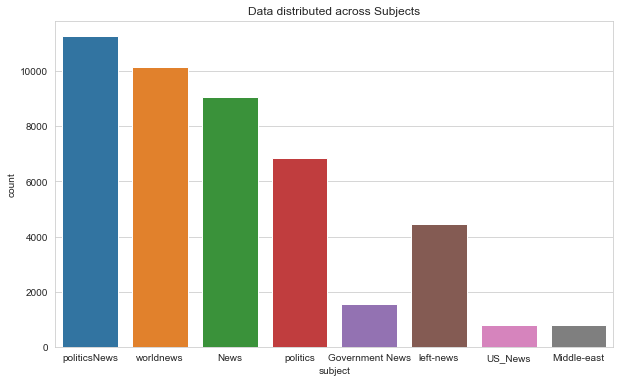

In [71]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=isot_data)
plt.title('Data distributed across Subjects')
plt.show()

In [77]:
# Dropping columns that we won't be needing and renaming the remaining features as per standard convention

isot_data = isot_data.rename(columns={'text':'body'})
# While time information would have been really useful in helping us understand the model's performance because of time based splitting, we'll have to drop it as the other
# datasets do not contain time information
isot_data.drop(['subject', 'date'], axis=1, inplace=True)

In [78]:
# Adding lengths of the title and body features in the same way they were added for dataset 1

title_num_words, title_num_letters = get_length(isot_data['title'])
body_num_words, body_num_letters = get_length(isot_data['body'])

isot_data['title_num_words'] = title_num_words
isot_data['title_num_letters'] = title_num_letters
isot_data['body_num_words'] = body_num_words
isot_data['body_num_letters'] = body_num_letters

In [81]:
isot_data.head()

,title,body,label,title_num_words,title_num_letters,body_num_words,body_num_letters
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,10,64,749,4659
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,9,64,624,4077
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,10,60,457,2789
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,9,59,376,2461
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,11,69,852,5204


In [82]:
isot_data.drop('label', axis=1).describe()

,title_num_words,title_num_letters,body_num_words,body_num_letters
count,44898.000000,44898.000000,44898.000000,44898.000000
mean,12.453472,80.111720,405.282284,2469.109693
std,4.111476,25.379685,351.265595,2171.617091
min,1.000000,8.000000,0.000000,1.000000
25%,10.000000,63.000000,203.000000,1234.000000
50%,11.000000,73.000000,362.000000,2186.000000
75%,14.000000,91.000000,513.000000,3105.000000
max,42.000000,286.000000,8135.000000,51794.000000


In [83]:
# Saving the data

isot_data.to_csv('E:\Major project\data\isot_complete', index=False)

## Basic high level analysis of the three datasets

   While we know that datasets 2 and 3 have no missing data, dataset 1 has 500+ missing articles which is quite a lot. It would make sense to have it filled. How to fill missing data in case of text is however tricky. 
    But before we go forward with combining the three dataset, we can check whether the distributions of the datasets are the same or different. This will come in handy when deciding if we want to fill the missing data in dataset 1
    using only dataset 1 data or using the combined data

In [2]:
# Reading all three datafile. 
# Here, data1 --> Kaggle_1 data
#       data2 --> Kaggle_2 data
#       data3 --> Isot data

data1 = pd.read_csv('E:\Major project\data\kaggle_1_filtered')
data2 = pd.read_csv('E:\Major project\data\kaggle_2_filtered')
data3 = pd.read_csv('E:\Major project\data\isot_complete')

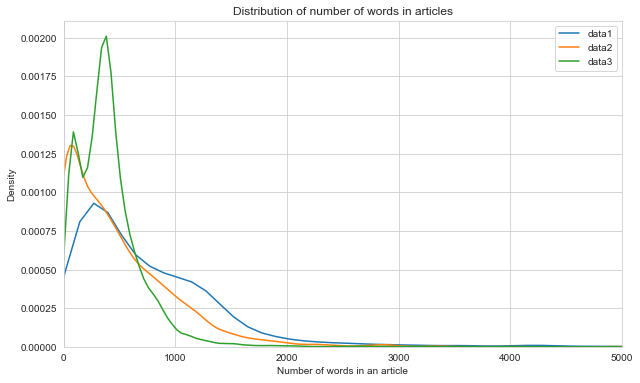

In [3]:
plt.figure(figsize=(10,6))
sns.kdeplot(data1['body_num_words'], label='data1')
sns.kdeplot(data2['body_num_words'], label='data2')
sns.kdeplot(data3['body_num_words'], label='data3')
plt.xlim(0,5000)
plt.xlabel('Number of words in an article')
plt.title('Distribution of number of words in articles')
plt.legend()
plt.show()

These distributions are pretty skewed. Thus it'd make sense to use median as the measure of central tendency for the three datasets

In [60]:
# Compaing the medians of the number of words present in the articles in the three datasets

print(f"The median number of words in each article in dataset 1 is: {data1['body_num_words'].median()}")
print(f"The median number of words in each article in dataset 2 is: {data2['body_num_words'].median()}")
print(f"The median number of words in each article in dataset 3 is: {data3['body_num_words'].median()}")

The median number of words in each article in dataset 1 is: 567.0
The median number of words in each article in dataset 2 is: 351.5
The median number of words in each article in dataset 3 is: 362.0


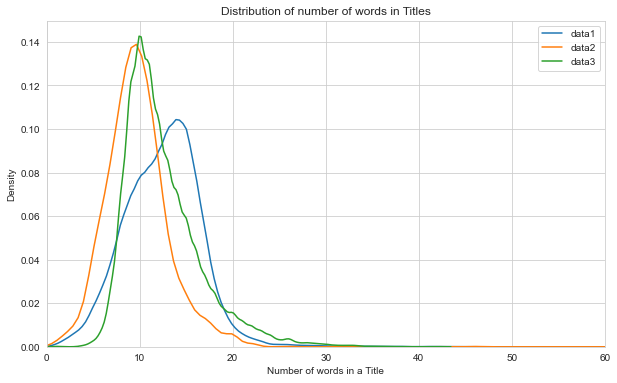

In [61]:
# We can carry out a similar analysis on the lengths of the titles

plt.figure(figsize=(10,6))
sns.kdeplot(data1['title_num_words'], label='data1')
sns.kdeplot(data2['title_num_words'], label='data2')
sns.kdeplot(data3['title_num_words'], label='data3')
plt.xlim(0,60)
plt.xlabel('Number of words in a Title')
plt.title('Distribution of number of words in Titles')
plt.legend()
plt.show()

As compared to the distributions that we see for the articles, the distributions of title lengths is not skewed and guassian in nature to a great extent. Thus for this, we can use Mean as a measure of central tendency

In [62]:
# Compaing the average number of words present in the titles in the three datasets

print(f"The average number of words in each article in dataset 1 is: {data1['title_num_words'].mean()}")
print(f"The average number of words in each article in dataset 2 is: {data2['title_num_words'].mean()}")
print(f"The average number of words in each article in dataset 3 is: {data3['title_num_words'].mean()}")

The average number of words in each article in dataset 1 is: 12.477749619868222
The average number of words in each article in dataset 2 is: 9.78986960882648
The average number of words in each article in dataset 3 is: 12.453472315025168


### Observations:
* Its clear that the datasets differ in the lengths of articles
* While datasets 2 and 3 have similar sized articles, articles coming from dataset 1 are much longer
* The titles however are around the same size in all of three datasets

## Filling missing data 

    We had about 528 missing datapoints in dataset 1. Now one way to deal with missing data is to drop them. But we would lose information from 528 articles. One thing to notice is that it is the title of the articles that is missing for these 528 datapoints. And since the titles are usually much smaller when compared to articles, we can try coming up with a workaround to this missing data problem. 

In [63]:
# Missing data in the first dataset

data1.isna().sum()

title                528
body                   0
label                  0
title_num_words      528
title_num_letters    528
body_num_words         0
body_num_letters       0
dtype: int64

In [64]:
# Adding a column that signifies whether the datapoint has any missing value

data1['missing_data'] = data1['title'].apply(pd.isna).map({True:1, False:0})

In [65]:
# Now that we have information about what datapoints have missing data, we can check what class does this missing data comes from.
# The idea behind this is what if more missing data comes from fake articles?

data1[data1['missing_data']==1]['label'].value_counts()

1    528
Name: label, dtype: int64

 This tells us that all the missing data present in the dataset belongs to class 1 which are Fake articles. 

#### An idea that we'll try using to fill missing titles is as follows: 

* Often title is a short summary of what the article is about in a few words. Its used to capture the attention of the reader and thus holds decent amount of information
* What can be seen in a lot of datapoints is that often the title has words that occur at the start of the article
* The idea is what if we use the starting few words from the body of these missing examples to fill in for the title. Its obviously better than discarding the datapoints altogether
* Next logical question would be how many words to pick up? For this we can use the median/mean number or words present in titles in dataset 1
* Also since we saw that all these missing points come from fake articles, we can try using the mean/median of number of words present in the fake articles

In [66]:
avg_letter_num_title = data1[data1['label'] == 1]['title_num_letters'].mean()
avg_word_num_title = data1[data1['label'] == 1]['title_num_words'].mean()

In [67]:
print(f'On average there are about {np.ceil(avg_word_num_title)} words in the titles')
print(f'On average there are about {np.ceil(avg_letter_num_title)} letters in the titles')

On average there are about 12.0 words in the titles
On average there are about 69.0 letters in the titles


In [68]:
# lets use the first 70 letters from the articles of data having missing titles
missing_idx = []  # To store all instances where titles were missing
for idx_missing, bool_value in enumerate(data1['missing_data']):
    if bool_value:  # If missing data
        text_to_fill = ' '.join(data1['body'].iloc[idx_missing].split()[:12])   # Taking the first 12 words in the body
        data1['title'].iloc[idx_missing] = text_to_fill
        missing_idx.append(idx_missing)  # Append the index of the missing title

In [72]:
# Now since all titles are filled, we can also fill the remaining

data1['title_num_words'] = data1['title_num_words'].fillna(12)  # Filling with average length of words in title
data1['title_num_letters'] = data1['title_num_letters'].fillna(69) # Filling with average length of letters in title

In [73]:
# Checking if missing titles have been filled

data1.isna().sum()

title                0
body                 0
label                0
title_num_words      0
title_num_letters    0
body_num_words       0
body_num_letters     0
missing_data         0
dtype: int64

In [85]:
# Checking the titles that were previously missing and were thus filled

for i,title in enumerate(data1[data1['missing_data'] == 1]['title']):
    if i > 9:
        break
    print(f'\nTitle {i+1}: {title}\n')
    print('_' * 90)


Title 1: Sounds like he has our president pegged. What a shame, Obama's ineptness

__________________________________________________________________________________________

Title 2: Same people all the time , i dont know how you can

__________________________________________________________________________________________

Title 3: You know, outside of any morality arguments, it seems to me that

__________________________________________________________________________________________

Title 4: There is a lot more than meets the eye to this mob

__________________________________________________________________________________________

Title 5: They got the heater turned up on high.

__________________________________________________________________________________________

Title 6: If I were one of those Guardsmen and the Spetsnaz came parachuting

__________________________________________________________________________________________

Title 7: The way he's doing business ther

## Combining the three datasets

   Now that we've dealt with the basic issues with the datsets, we can combine them. Once we have the combined data, we can further move on to exploring and cleaning the data

In [87]:
# Dropping 'missing_data' column from dataset 1

data1.drop('missing_data', axis=1, inplace=True)

In [88]:
# Concatenating all the datasets

data = pd.concat([data1, data2, data3], ignore_index=True)

In [100]:
data.head()

,title,body,label,title_num_words,title_num_letters,body_num_words,body_num_letters
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,14.0,81.0,820.0,4930.0
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,9.0,55.0,710.0,4160.0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,7.0,33.0,1266.0,7692.0
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,10.0,63.0,557.0,3237.0
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,14.0,93.0,154.0,938.0


In [98]:
print(f"We have a total of {data.shape[0]} datapoints in the final dataset")

We have a total of 69144 datapoints in the final dataset


In [4]:
# Dropping everthing except title and body

data.drop(['title_num_words','title_num_letters','body_num_words', 'body_num_letters'], axis=1,inplace=True)
data.head()

,title,body,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


In [101]:
# Saving the data

data.to_csv('E:\Major project\data\complete_data', index=False)

# Data Cleaning

Now that we have combined all the data, the next important part is to clean the Data itself. <br>
We mainly have titles and the body which would need cleaning. Cleaning the data could involve various steps. For example, getting rid of the html tags, if present in the data. Similarly, we could get rid of the stuff like stop words, punctuation, etc <br>
Once we've cleaned the data, we can try using techniques like stemming / lemmatization so that words like <em>'study'</em> and <em>'studying'</em> are not treated differently. <br>
The text also contains stuff like emojis that can be taken care of


In [134]:
# Reading the data

data = pd.read_csv('E:\Major project\data\complete_data')

In [15]:
# Checking random titles

data['title'][600]

'Bill Clinton’s Lover: He Called Ruthless Hillary ‘The Warden’'

In [16]:
data['title'][1606]

'West covering up crimes of Bahraini regime: Analyst'

In [17]:
# Checking random articles

data['body'][5666]

'NFL players may soon get a reminder of how the “other half” lives, at least when it comes to travel. [According to Forbes, American Airlines suspended its charter arrangements with six NFL teams. The teams that will no longer fly American are the Cardinals, Ravens, Colts, Jaguars, Dolphins, and Steelers.  However, weirdly, American will continue to provide charters for the Cowboys, Panthers, and Eagles. American cites a lack of machinery as the reason for the discontinuation of service. According to Pro Football Talk, the charter suspension issue, “  …    extends beyond American Airlines. Delta is believed to be doing the same thing, and United could be next. The source said that roughly 20 teams currently don’t have a charter provider for the coming season, and that it could become a ‘real issue’ for the league. ” How amazing that in a league where every owner, and even some athletes, use their own private planes, that chartering flights when traveling for work could become an issue.

In [18]:
data['body'][9]

'A week before Michael T. Flynn resigned as national security adviser, a sealed proposal was   to his office, outlining a way for President Trump to lift sanctions against Russia. Mr. Flynn is gone, having been caught lying about his own discussion of sanctions with the Russian ambassador. But the proposal, a peace plan for Ukraine and Russia, remains, along with those pushing it: Michael D. Cohen, the president’s personal lawyer, who delivered the document Felix H. Sater, a business associate who helped Mr. Trump scout deals in Russia and a Ukrainian lawmaker trying to rise in a political opposition movement shaped in part by Mr. Trump’s former campaign manager Paul Manafort. At a time when Mr. Trump’s ties to Russia, and the people connected to him, are under heightened scrutiny  —   with investigations by American intelligence agencies, the F. B. I. and Congress  —   some of his associates remain willing and eager to wade into   efforts behind the scenes. Mr. Trump has confounded De

In [20]:
# Referenced from: https://stackoverflow.com/a/47091490/4084039
# This will replace words like "won't" with "will not" and so on

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [32]:
stop_words = set(stopwords.words('English'))  # Loading in the stop words

In [33]:
# Removing words like no, nor and not from the stopwords dict

stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('nor')
print(stop_words)

{'out', 'haven', 'am', 'before', 'did', "aren't", 'if', 'up', 'can', "couldn't", 'yours', 'themselves', 'until', 'was', 'few', 'further', 'it', 'd', 'doesn', 'be', 'each', 'ours', 'then', 's', 'isn', 'were', "doesn't", "that'll", 'which', 'with', 'at', 'who', 'you', 'its', 'that', 'their', "weren't", "mightn't", 'through', 'during', 'after', 'why', 'under', 'most', 'doing', 'as', 'but', 'some', "you'd", 'our', 'an', 'they', 'on', 'more', 'once', 'your', 'own', 'o', "shouldn't", 'over', 'weren', 'll', 'she', 'because', 'about', 'hers', 'while', "needn't", 'so', "don't", 'my', "you'll", 'couldn', 'against', 'in', 'ourselves', 'should', 'aren', 'them', 'this', 'her', 'again', 'do', "haven't", 'only', 'wasn', 'him', 'have', "shan't", 'all', 'i', 'same', 'when', "you've", 're', 'we', 'didn', "won't", "it's", 'his', 'he', 'herself', 'from', 'for', 'very', 'are', 'has', 'too', 'don', 'won', 'wouldn', 'and', 'how', 'mustn', 'himself', 't', 'itself', 'a', 'yourselves', 'any', 'between', 'does',

In [34]:
# To get rid of emojis 
# Refernce: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

This is a smiley face 😂
This is a smiley face 


In [1]:
def clean_data(text, stem=False, lemmatize=False):
    
    """
    Given some text, this function cleans the text data
    
    Parameters: 
        text: A list / series containing text data
        stem: If stem == True, the cleaned text is also stemmed
        lemmatize: If lematize == True, the cleaned text is also lemmatized
        
        If both stem == False and lemmatize == False, text is only cleaned
        
    Output:
        The function returns a list containing the cleaned text
        
    """
    
    lemmatizer = WordNetLemmatizer()   
    stemmer = SnowballStemmer('english')
    
    cleaned_text = []
    for line in tqdm(text):
        
        cleaned_line = decontracted(line)
        cleaned_line = deEmojify(cleaned_line)  # Removing any emojis
        cleaned_line = cleaned_line.replace('\n',' ').replace('\t',' ')  # Replacing any tab or new line indicators
        cleaned_line = re.sub('[^A-Za-z0-9]+', ' ', cleaned_line)
        cleaned_line = ' '.join(word for word in cleaned_line.split() if word.lower() not in stop_words)  # Removing stop words
        cleaned_line = cleaned_line.lower().strip() # Append the cleaned text and convert all text to lower case letters and remove any whitespace 
        
        if stem:
            stemmed = []
            for word in cleaned_line.split():
                stemmed.append(stemmer.stem(word))
            cleaned_text.append(' '.join(stemmed))
                
        
        if lemmatize:
            lemmatized = []
            for word in cleaned_line.split():
                lemmatized.append(lemmatizer.lemmatize(word))
            cleaned_text.append(' '.join(lemmatized))
            
        if not stem and not lemmatize:
            cleaned_text.append(cleaned_line)
        
    return cleaned_text

In [160]:
data['title'] = clean_data(text=data['title'], stem=True)

100%|██████████████████████████████████████████████████████████████████████████| 69144/69144 [00:09<00:00, 7642.73it/s]


In [161]:
data['body'] = clean_data(text=data['body'], stem=True)

100%|███████████████████████████████████████████████████████████████████████████| 69144/69144 [04:34<00:00, 251.61it/s]


In [162]:
data.head()

,title,body,label
0,hous dem aid even see comey letter jason chaff...,hous dem aid even see comey letter jason chaff...,1
1,flynn hillari clinton big woman campus breitbart,ever get feel life circl roundabout rather hea...,0
2,truth might get fire,truth might get fire octob 29 2016 tension int...,1
3,15 civilian kill singl us airstrik identifi,video 15 civilian kill singl us airstrik ident...,1
4,iranian woman jail fiction unpublish stori wom...,print iranian woman sentenc six year prison ir...,1


In [163]:
data.to_csv('E:\Major project\data\stemmed_clean_data', index=False)  # Saving the stemmed data

In [164]:
# Creating lemmatized data

data = pd.read_csv('E:\Major project\data\complete_data')  # Uncleaned complete data

In [165]:
data['title'] = clean_data(text=data['title'], lemmatize=True)

100%|█████████████████████████████████████████████████████████████████████████| 69144/69144 [00:03<00:00, 18673.19it/s]


In [166]:
data['body'] = clean_data(text=data['body'], lemmatize=True)

100%|███████████████████████████████████████████████████████████████████████████| 69144/69144 [01:37<00:00, 708.58it/s]


In [167]:
data.to_csv('E:\Major project\data\lemmatized_clean_data', index=False)  # Saving the lemmatized data

In [168]:
data.head()

,title,body,label
0,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


## Comparing the cleaned stemmed and cleaned lemmatized data

In [176]:
uncleaned = pd.read_csv('E:\Major project\data\complete_data')
stemmed = pd.read_csv('E:\Major project\data\stemmed_clean_data')
lemmatized = pd.read_csv('E:\Major project\data\lemmatized_clean_data')

In [189]:
# comparing the titles for the first datapoint

print(f"Original-uncleaned title:\n\n {uncleaned['title'][0]}")
print('_'*85)
print(f"\nCleaned-Lemmatized title:\n\n {lemmatized['title'][0]}")
print('_'*85)
print(f"\nCleaned-Stemmed title:\n\n {stemmed['title'][0]}")
print('_'*85)

Original-uncleaned title:

 House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
_____________________________________________________________________________________

Cleaned-Lemmatized title:

 house dem aide even see comey letter jason chaffetz tweeted
_____________________________________________________________________________________

Cleaned-Stemmed title:

 hous dem aid even see comey letter jason chaffetz tweet
_____________________________________________________________________________________


In [190]:
# comparing the titles for the hundredth datapoint

print(f"Original-uncleaned title:\n\n {uncleaned['title'][100]}")
print('_'*85)
print(f"\nCleaned-Lemmatized title:\n\n {lemmatized['title'][100]}")
print('_'*85)
print(f"\nCleaned-Stemmed title:\n\n {stemmed['title'][100]}")
print('_'*85)

Original-uncleaned title:

 Hillary Clinton Builds $150 Million War Chest, Doubling Donald Trump - The New York Times
_____________________________________________________________________________________

Cleaned-Lemmatized title:

 hillary clinton build 150 million war chest doubling donald trump new york time
_____________________________________________________________________________________

Cleaned-Stemmed title:

 hillari clinton build 150 million war chest doubl donald trump new york time
_____________________________________________________________________________________
